# ARIMAX Model

In [1]:
from _Setup import *
from _Functions import *

Installing dependencies from requirements.txt...
All dependencies installed successfully.


In [ ]:
# Load data as csv
sector_train = pd.read_csv(sector_data_csv_path_train_pivoted, index_col='Area of Responsibility')

# Import the scaler
with open(scalers_file, "rb") as file:
    scalers = pickle.load(file)

# DONE : Create scaled version of original Dataframe
# Apply pre-trained scalers row-wise

# Create an empty DataFrame to store scaled values
sector_train_scaled = pd.DataFrame(index=sector_train.index, columns=sector_train.columns)

# Apply each pre-trained scaler row-wise
for index, row in sector_train.iterrows():
	scaler = scalers[index]
	scaled_row = scaler.transform(row.values.reshape(-1, 1)).flatten()
	sector_train_scaled.loc[index] = scaled_row

sector_train_scaled.head()

,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,...,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01
Area of Responsibility,,,,,,,,,,,,,,,,,,,,,
Atlanta Field Office,0.309259,0.148765,0.026543,0.003704,0.0,0.201235,0.318519,1.0,0.624074,0.559877,...,0.388272,0.244444,0.401852,0.287654,0.340741,0.267284,0.329012,0.324691,0.340741,0.301235
Baltimore Field Office,0.202374,0.26286,0.323912,0.346523,0.325042,0.159412,0.0,0.052007,0.036744,0.017524,...,0.940079,0.851328,0.811758,0.821933,0.836631,0.848502,0.765969,0.681176,0.66026,0.74788
Big Bend Sector,0.090589,0.064323,0.067839,0.080455,0.071768,0.09514,0.060393,0.085419,0.092037,0.109824,...,0.071355,0.054602,0.04364,0.02213,0.022544,0.073009,0.045708,0.064943,0.110858,0.0
Blaine Sector,0.091463,0.067073,0.103659,0.070122,0.07622,0.042683,0.012195,0.033537,0.009146,0.039634,...,0.658537,0.692073,0.597561,0.881098,0.67378,0.710366,0.682927,1.0,0.804878,0.545732
Boston Field Office,0.242847,0.171496,0.272365,0.16226,0.234698,0.100869,0.0431,0.0,0.040746,0.027888,...,1.0,0.61427,0.578776,0.757334,0.806592,0.644151,0.847881,0.88573,0.861101,0.807678


In [4]:
# Create a binary row
binary_row = pd.Series(
    data=[1 if col < '2020-11-01' or col > '2024-10-01' else 0 for col in sector_train_scaled.columns],
    index=sector_train_scaled.columns,
    name='binary'
)

# Append the binary row to the dataframe using pd.concat
sector_train_scaled = pd.concat([sector_train_scaled, binary_row.to_frame().T])

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
import itertools
import warnings

warnings.filterwarnings("ignore")

p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
pdq_combinations = list(itertools.product(p_values, d_values, q_values))
fixed_pdq_combinations = [tuple(int(value) for value in order) for order in pdq_combinations]

mapes = []
predictions_dict = {}

# Extract exogenous variable from the 'binary' row
binary_exog = pd.to_numeric(sector_train_scaled.loc['binary'], errors='coerce').values.reshape(-1, 1)

# Drop 'binary' row from the input dataset to iterate only over actual time series
series_df = sector_train_scaled.drop(index='binary', errors='ignore')

for index, row in series_df.iterrows():
    try:
        input_series = pd.to_numeric(row, errors='coerce').dropna().values.flatten()

        if len(input_series) < 3:
            print(f"Skipping index {index}: Not enough data points.")
            continue

        if binary_exog.shape[0] != len(input_series):
            print(f"Skipping index {index}: Exogenous variable length mismatch.")
            continue

        best_aic = float("inf")
        best_order = None
        best_model = None
        best_residuals = None

        for order in fixed_pdq_combinations:
            try:
                model = SARIMAX(input_series, exog=binary_exog, order=order,
                                enforce_stationarity=False, enforce_invertibility=False)
                fitted_model = model.fit(disp=False)
                aic = fitted_model.aic

                if aic < best_aic:
                    best_aic = aic
                    best_order = order
                    best_model = fitted_model
                    best_residuals = np.array(fitted_model.resid)

            except Exception as e:
                print(f"Skipping SARIMAX{order} for index {index}: {e}")
                continue

        # Inverse transform for evaluation
        row_array = np.array(row)
        true_values = scalers[index].inverse_transform(row_array.reshape(-1, 1)).flatten()
        pred_values = true_values - scalers[index].inverse_transform(best_residuals.reshape(-1, 1)).flatten()

        nonzero_mask = true_values != 0
        if not np.any(nonzero_mask):
            print(f"Skipping index {index}: All true values are zero after inverse transform.")
            continue

        mape = np.mean(np.abs((true_values[nonzero_mask] - pred_values[nonzero_mask]) / true_values[nonzero_mask])) * 100
        mapes.append(mape)

        # Forecast 6 steps ahead using exog = 1 for all 6 future time steps
        future_exog = np.array([0, 0, 0, 0, 1, 1]).reshape(-1, 1)

        forecast = best_model.get_forecast(steps=6, exog=future_exog)
        forecast_mean = forecast.predicted_mean

        # Inverse transform the forecast
        forecast_inverted = scalers[index].inverse_transform(forecast_mean.reshape(-1, 1)).flatten()

        # Store the forecast
        predictions_dict[index] = forecast_inverted


    except Exception as e:
        print(f"Skipping index {index} due to unexpected error: {e}")


In [12]:
predictions_dict

{'Atlanta Field Office': array([1102.00627798, 1121.91985069, 1170.61191734, 1175.70201783,
        1161.97793699, 1156.20309219]),
 'Baltimore Field Office': array([1399.77259198, 1391.59634817, 1383.47095039, 1375.39608244,
        1359.21964418, 1351.24489514]),
 'Big Bend Sector': array([215.        , 215.        , 215.        , 215.        ,
        106.29247296, 106.29247296]),
 'Blaine Sector': array([251.86957281, 232.01055464, 212.31121526, 192.90677201,
        174.94420307, 156.47449253]),
 'Boston Field Office': array([4903.09723084, 5028.01523624, 5156.15126497, 5287.58821682,
        5553.51058148, 5691.80667624]),
 'Buffalo Field Office': array([4897.37110802, 4862.00552613, 4826.90130838, 4792.05652318,
        5109.22663004, 5074.89497225]),
 'Buffalo Sector': array([30.42807817, 39.48956244, 32.23993123, 38.03999125, 43.25162154,
        46.96411447]),
 'Chicago Field Office': array([2111.60184546, 2076.82033921, 2042.64473904, 2009.06448983,
        1999.95852153, 19

In [13]:
test_data = pd.read_csv(sector_data_csv_path_test_pivoted, index_col='Area of Responsibility')
test_data.head()

,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01
Area of Responsibility,,,,,,
Atlanta Field Office,915,869,951,667,484,470
Baltimore Field Office,1126,1226,1136,1156,1171,950
Big Bend Sector,214,308,349,291,282,503
Blaine Sector,99,66,63,69,58,34
Boston Field Office,3989,3452,3432,2684,2031,2277


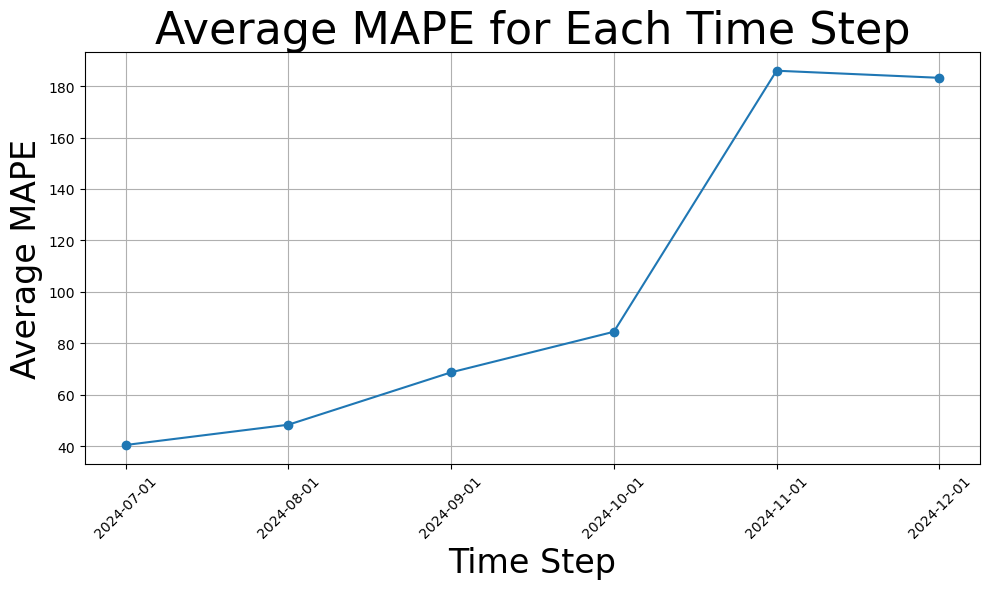

In [20]:
def calculate_mape(predictions, actuals):
    return np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Initialize a dictionary to store MAPE values for each time step
mape_dict = {col: [] for col in test_data.columns}

# Iterate over each index in the predictions dictionary
for index, predictions in predictions_dict.items():
    if index in test_data.index:
        actuals = test_data.loc[index].values
        for i, col in enumerate(test_data.columns):
            if i < len(predictions):
                mape = calculate_mape(predictions[i], actuals[i])
                mape_dict[col].append(mape)

# Calculate the average MAPE for each time step
average_mape_dict = {col: np.mean(mapes) for col, mapes in mape_dict.items()}
import matplotlib.pyplot as plt

# Plot the average MAPE for each time step
plt.figure(figsize=(10, 6))
plt.plot(list(average_mape_dict.keys()), list(average_mape_dict.values()), marker='o')
plt.title('Average MAPE for Each Time Step', fontsize=32)
plt.xlabel('Time Step', fontsize=24)
plt.ylabel('Average MAPE', fontsize=24)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

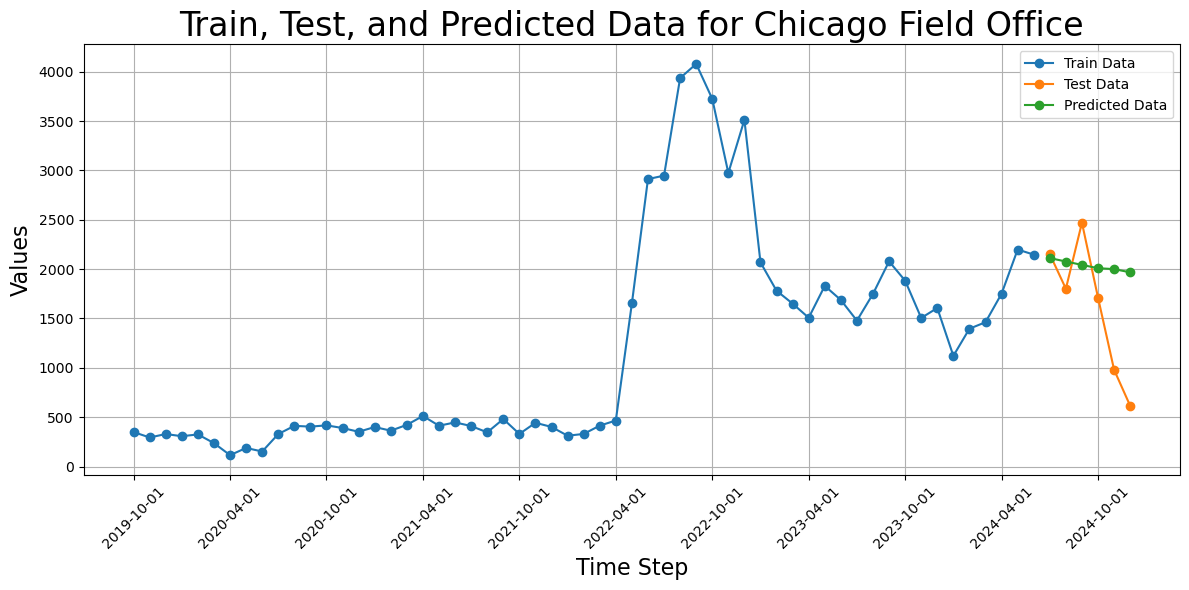

In [25]:
import matplotlib.pyplot as plt

# Ensure "Del Rio Sector" exists in all necessary structures
sector_name = "Chicago Field Office"

if (
    sector_name in sector_train_scaled.index 
    and sector_name in test_data.index 
    and sector_name in predictions_dict
):
    # Inverse transform train data
    train_series = sector_train_scaled.loc[sector_name]
    train_data = scalers[sector_name].inverse_transform(train_series.values.reshape(-1, 1)).flatten()
    
    # Extract test and predicted data
    test_series = test_data.loc[sector_name].astype(float)
    predicted_data = predictions_dict[sector_name]

    # Create time indices
    train_index = train_series.index if hasattr(train_series, "index") else range(len(train_data))
    test_index = test_series.index

    # Concatenate time steps for tick control
    full_index = list(train_index) + list(test_index)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(train_index, train_data, label="Train Data", marker='o')
    plt.plot(test_index, test_series.values, label="Test Data", marker='o')
    plt.plot(test_index[:len(predicted_data)], predicted_data, label="Predicted Data", marker='o')

    plt.title(f"Train, Test, and Predicted Data for {sector_name}", fontsize=24)
    plt.xlabel("Time Step", fontsize=16)
    plt.ylabel("Values", fontsize=16)
    plt.legend()
    plt.grid(True)

    # Set x-ticks to every 6th step
    xticks = full_index[::6]
    plt.xticks(ticks=xticks, rotation=45)

    plt.tight_layout()
    plt.show()

else:
    print(f"Data for {sector_name} is not available in train, test, or predictions.")
